In order to suggest a possible solution for the last WP, we have considered a solution using do-mpc tool. As well known, we need of a mathematical model so, for this reason, with the conditional pdf $f(x_k|x_{k-1},u_{k})$ we can build a dataset (considering each tuple $(u_{k}, x_{k-1})$) with the intention of using it for doing a regression procedure.

After that, we could use this model in our MPC model.

In [15]:
from gekko import GEKKO
import numpy as np
from matplotlib import pyplot as plt

In [16]:
#Parameters for f(x_k|x_{k-1},u_k)
a_c = 0.982
b_c = 0.2591
sigma_c = 13.059

#Parameters for g(x_k|x_{k-1},u_k)
a_e = 0.9811
b_e = 0.2723
sigma_e = 8.811

#Bounds for u (velocity) and x (distance)
v_min = 15
v_max = 85
d_min = 0
d_max = 1500

#Amount of bins (resolution) for u and x
v_discr = 100
d_discr = 100

In [17]:
d_step = (d_max-d_min)/d_discr # Discretization step for x
v_step = (v_max-v_min)/v_discr # Discretization step for u

x_axis = [d_min + (i+0.5)*d_step for i in range(d_discr)]
u_axis = [v_min + (j+0.5)*v_step for j in range(v_discr)]

In [18]:
def getPlant(a, b, sigma):
    # Function for getting the plant (f_x or g_x) from the parameters.
    # The arguments are the linear parameters for the mean and the std.
    # The Gaussians are simply coded as [mean, std] to simplify calculations
    res = np.zeros((d_discr,v_discr,2)) # Initializing the empty array
    for i in range(d_discr): # Iterating over the state space for x_{k-1}
        x_km1 = d_min + (i+0.5)*d_step # Calculating x_{k-1}
        for j in range(v_discr): # Iterating over the action space for u_k
            u_k = v_min + (j+0.5)*v_step  # Calculating u_k
            mu = a*x_km1 + b*u_k # Calculating the average of the Gaussian
            res[i][j] = [mu, sigma] # Adding the Gaussian in [mean, std] form to the array
    return(res)

In [19]:
def build_dataset():
    xkm1L = []
    xkL = []
    ukL = []
    
    f_x = getPlant(a_c, b_c, sigma_c) 
    for xkm1 in range(d_discr): #for each previous state
        for uk in range(v_discr): #for each control input
            
            plant = f_x[xkm1][uk] #gaussian expression given xkm1 and uk
            
            # True values for uk, xkm1 and x
            trueX = np.random.normal(plant[0], plant[1])
            trueXkm1 = xkm1*d_step + d_min
            trueU = uk*v_step + v_min
            
            x = int(trueX-d_min)//d_step
            x = min(x, d_discr - 1)
            x = max(x, 0)
            
            if x > xkm1: #if we can reach a next (real) state from the previous state 
                ukL.append(trueU)
                xkm1L.append(trueXkm1)
                xkL.append(trueX)

    return xkm1L, xkL, ukL


In [20]:
# measurements
xkm1L, xkL, ukL = build_dataset()

xkm1L = np.array(xkm1L) #array of the previous states
ukL = np.array(ukL) #array of the control inputs 
xkL = np.array(xkL) #array of the next states


# GEKKO model
m = GEKKO()

# parameters
xkm1 = m.Param(value=xkm1L)
uk = m.Param(value=ukL)

# fixed variables
a = m.FV()
a.STATUS=1

b = m.FV()
b.STATUS=1

# controlled variable
xk = m.CV(value=xkL)
xk.FSTATUS=1

# regression equation
m.Equation(xk== a*xkm1 + b*uk)

# regression mode
m.options.IMODE = 2

# optimize
m.solve(disp=False)

# print parameters
print('Optimized, a = ' + str(a.value[0]))
print('Optimized, b = '+ str(b.value[0]))


Optimized, a = 0.99931204848
Optimized, b = 0.39271844869


After we have obtained the parameters $a$ and $b$ we can use them in MPC_do_mpc.ipynb in order to define an approximated mathematical model of the system.

The next plot represents if the function obtained from the regression is a good approximation.

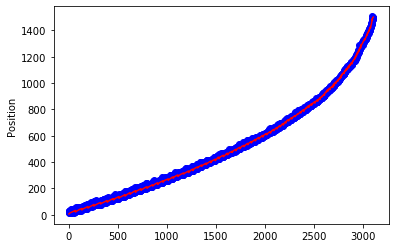

In [23]:
plt.ylabel("Position")
plt.plot(xkL,'bo')
plt.plot(xk.value,'r-')